In [ ]:
# =============================================================================
#                            Imports & Config
# =============================================================================
import tensorflow as tf           # Core TensorFlow library for neural networks
import numpy as np                # Numerical operations (unused here but often needed)
import matplotlib.pyplot as plt   # Plotting library
from matplotlib import rcParams   # Matplotlib configuration

# =============================================================================
#                       Neural Network Hyperparameters
# =============================================================================
NN      = 10      # Number of neurons per hidden layer
NL      = 5       # Total number of hidden layers (excluding input & output)
N_points= 500     # Collocation points sampling the domain for training
N_epoch = 10000   # Number of epochs for model training

# =============================================================================
#                     PDE Source & Exact Solution Functions
# =============================================================================
def f_source(x):
    """
    Right‑hand side source function for the PDE: -Δu = f.
    """
    return -4 * tf.sin(2 * x)

def uexact(x):
    """
    Known analytical solution u(x) = sin(2x) for comparison/testing.
    """
    return tf.sin(2 * x)

# =============================================================================
#                   Neural Network Architecture Definition
# =============================================================================
# Input layer: scalar x-coordinate
X = tf.keras.layers.Input(shape=(1,))

# First hidden layer: NN neurons with tanh activation
L = tf.keras.layers.Dense(units=NN, activation='tanh')(X)

# Additional hidden layers: NL‑1 layers of the same size
for _ in range(NL - 1):
    L = tf.keras.layers.Dense(units=NN, activation='tanh')(L)

# Output layer: single neuron for scalar u(x)
LO = tf.keras.layers.Dense(units=1, activation='tanh')(L)

# Build the Keras model
U_model = tf.keras.Model(inputs=X, outputs=LO, name='U_model')

# =============================================================================
#                        Model Summary & Visualization
# =============================================================================
# Print model architecture details to console
U_model.summary()



2025-02-08 15:56:01.270620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "U_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471 (1.84 KB)

 Trainable params: 471 (1.84 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# =============================================================================
#                                Imports
# =============================================================================
import tensorflow as tf
import numpy as np

# =============================================================================
#                       Neural Network & PDE Settings
# =============================================================================
# U_model   → Neural network approximating u(x)
# N_points  → Number of collocation points for sampling domain
# f_source  → Source function for PDE: -Δu = f
# N_epoch   → Number of training epochs
# (Assumes U_model, N_points, f_source, N_epoch have been defined earlier)

# =============================================================================
#                Custom Loss Layer: PDE Residual + Boundary Conditions
# =============================================================================
class loss(tf.keras.layers.Layer):
    """
    Computes the PDE residual loss for -Δu = f along with boundary losses.
    """
    def __init__(self, U_model, N_points, f_source, **kwargs):
        super(loss, self).__init__()
        self.U_model  = U_model    # NN model approximating u(x)
        self.N_points = N_points   # number of collocation points
        self.f_source = f_source   # PDE source function

    def call(self, inputs):
        """
        inputs: dummy tensor (not used) to fit Keras API.

        Returns:
          loss_out: scalar tensor combining PDE residual and BC losses.
        """
        # -- 1) Sample points in [0, π] and include the boundaries --
        random_points = tf.random.uniform(
            shape=(self.N_points,),
            minval=0.0, maxval=np.pi,
            dtype=tf.float32
        )
        extremes      = tf.concat([[0.0], random_points, [np.pi]], axis=0)
        sorted_points = tf.sort(extremes)

        # -- 2) Compute midpoints and interval sizes for quadrature if needed --
        S              = (sorted_points[:-1] + sorted_points[1:]) / 2
        interval_sizes = sorted_points[1:] - sorted_points[:-1]

        # -- 3) Compute second derivative u_xx via nested GradientTapes --
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(S)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(S)
                ueval = self.U_model(S)           # u(x) at sample points
                u_x   = t2.gradient(ueval, S)     # du/dx
            u_xx = t1.gradient(u_x, S)           # d²u/dx²

        # -- 4) PDE residual: (u_xx - f(x))² averaged over samples --
        f_vals   = self.f_source(S)              # f(x) at sample points
        loss_out = tf.reduce_mean((u_xx - f_vals) ** 2)

        # -- 5) Enforce boundary conditions: u(0)=0 and u(π)=0 --
        loss_out += self.U_model(np.array([0.]))**2
        loss_out += self.U_model(np.array([np.pi]))**2

        return loss_out

# =============================================================================
#              Helper to Wrap Custom Loss as a Keras Model
# =============================================================================
def loss_model(U_model, N_points, f_source):
    """
    Creates a Keras model whose output is the computed custom loss.
    """
    Xl = tf.keras.layers.Input(shape=(1,))  # Dummy input
    loss_layer = loss(U_model, N_points, f_source)(Xl)
    return tf.keras.Model(inputs=Xl, outputs=loss_layer)

# =============================================================================
#                       Loss Extraction Function
# =============================================================================
def loss_value(x, y):
    """
    Extracts the scalar loss from the model’s output.
    """
    return y

# =============================================================================
#                       Assemble & Compile Training Model
# =============================================================================
# 1) Build the loss model that computes PDE + BC loss
model_all = loss_model(U_model, N_points, f_source)

# 2) Choose optimizer (Adam with learning rate 1e-3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# 3) Compile with our loss extraction function
model_all.compile(optimizer=optimizer, loss=loss_value)

# =============================================================================
#                          Train the Model
# =============================================================================
# Use dummy data (triggers loss computation)
history = model_all.fit(
    x=np.array([1.]),  # dummy input
    y=np.array([1.]),  # dummy target
    epochs=N_epoch     # number of training epochs
)


Epoch 1/10000
[[7.63236856]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 7.6324
Epoch 2/10000
[[8.22306252]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 8.2231
Epoch 3/10000
[[7.72854757]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 7.7285
Epoch 4/10000
[[7.80173349]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 7.8017
Epoch 5/10000
[[7.3424716]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 7.3425
Epoch 6/10000
[[7.55490923]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 7.5549
Epoch 7/10000
[[7.63198376]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 7.6320
Epoch 8/10000
[[7.34920406]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 7.3492
Epoch 9/10000
[[7.65787649]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 7.6579
Epoch 10/10000
[[7.56053495]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7.5605
Epoch 11/10000
[[7.37221098]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 7.3722
Epoch 12/10000
[[7.43383503]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 7.4338
Epoch 13/10000
[

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 3.0004
Epoch 135/10000
[[2.84550428]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.8455
Epoch 136/10000
[[3.07061148]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.0706
Epoch 137/10000
[[3.10996556]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.1100
Epoch 138/10000
[[3.13315511]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.1332
Epoch 139/10000
[[3.15294838]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.1529
Epoch 140/10000
[[3.13769269]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 3.1377
Epoch 141/10000
[[3.05346918]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.0535
Epoch 142/10000
[[3.15065718]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.1507
Epoch 143/10000
[[2.98892283]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.9889
Epoch 144/10000
[[3.20586896]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.2059
Epoch 145/10000
[[3.18474793]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3.1847
Epoch 146/10000
[[2.993

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.7387
Epoch 273/10000
[[2.6079843]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.6080
Epoch 274/10000
[[2.71671772]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.7167
Epoch 275/10000
[[2.8302474]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2.8302
Epoch 276/10000
[[2.82667065]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.8267
Epoch 277/10000
[[2.80966735]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.8097
Epoch 278/10000
[[2.75065136]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.7507
Epoch 279/10000
[[2.81488776]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.8149
Epoch 280/10000
[[2.65354443]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2.6535
Epoch 281/10000
[[2.59968328]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.5997
Epoch 282/10000
[[2.54815817]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.5482
Epoch 283/10000
[[2.6125102]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.6125
Epoch 284/10000
[[2.628632

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7828
Epoch 411/10000
[[0.881755412]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.8818
Epoch 412/10000
[[0.856751561]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.8568
Epoch 413/10000
[[0.850878]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8509
Epoch 414/10000
[[0.839025736]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.8390
Epoch 415/10000
[[0.703643858]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.7036
Epoch 416/10000
[[0.871417284]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.8714
Epoch 417/10000
[[0.780103326]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.7801
Epoch 418/10000
[[0.799557447]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.7996
Epoch 419/10000
[[0.749129474]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.7491
Epoch 420/10000
[[0.785625398]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.7856
Epoch 421/10000
[[0.707400799]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.7074
Epoch 422/10000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.4258
Epoch 549/10000
[[0.45941928]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4594
Epoch 550/10000
[[0.43193543]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.4319
Epoch 551/10000
[[0.447435528]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.4474
Epoch 552/10000
[[0.432765543]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4328
Epoch 553/10000
[[0.439824104]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4398
Epoch 554/10000
[[0.455162436]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4552
Epoch 555/10000
[[0.459056973]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4591
Epoch 556/10000
[[0.440891206]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.4409
Epoch 557/10000
[[0.433521241]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.4335
Epoch 558/10000
[[0.361713767]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3617
Epoch 559/10000
[[0.462951541]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.4630
Epoch 560/1000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.4518
Epoch 618/10000
[[0.447716802]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.4477
Epoch 619/10000
[[0.379041731]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3790
Epoch 620/10000
[[0.395210326]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3952
Epoch 621/10000
[[0.385290176]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3853
Epoch 622/10000
[[0.42103976]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.4210
Epoch 623/10000
[[0.385430813]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3854
Epoch 624/10000
[[0.40871194]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.4087
Epoch 625/10000
[[0.42023319]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.4202
Epoch 626/10000
[[0.447316825]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.4473
Epoch 627/10000
[[0.448010683]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.4480
Epoch 628/10000
[[0.444619268]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.4446
Epoch 629/10000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.4049
Epoch 687/10000
[[0.378979951]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3790
Epoch 688/10000
[[0.43573305]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.4357
Epoch 689/10000
[[0.371503919]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3715
Epoch 690/10000
[[0.366525173]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3665
Epoch 691/10000
[[0.36892283]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3689
Epoch 692/10000
[[0.419142634]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.4191
Epoch 693/10000
[[0.378561258]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3786
Epoch 694/10000
[[0.39911586]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3991
Epoch 695/10000
[[0.35894689]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3589
Epoch 696/10000
[[0.387947083]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3879
Epoch 697/10000
[[0.40626204]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4063
Epoch 698/10000
[

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3488
Epoch 756/10000
[[0.360169947]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3602
Epoch 757/10000
[[0.36177054]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3618
Epoch 758/10000
[[0.344817281]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3448
Epoch 759/10000
[[0.368631899]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3686
Epoch 760/10000
[[0.357933402]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3579
Epoch 761/10000
[[0.35651952]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3565
Epoch 762/10000
[[0.34188661]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3419
Epoch 763/10000
[[0.391522288]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3915
Epoch 764/10000
[[0.374785095]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3748
Epoch 765/10000
[[0.338805944]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3388
Epoch 766/10000
[[0.360991806]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3610
Epoch 767/10000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3365
Epoch 825/10000
[[0.354398876]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3544
Epoch 826/10000
[[0.336532623]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3365
Epoch 827/10000
[[0.316068321]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3161
Epoch 828/10000
[[0.357690483]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3577
Epoch 829/10000
[[0.33346954]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3335
Epoch 830/10000
[[0.310061246]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3101
Epoch 831/10000
[[0.355865151]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3559
Epoch 832/10000
[[0.315242529]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3152
Epoch 833/10000
[[0.317058623]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3171
Epoch 834/10000
[[0.344204932]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3442
Epoch 835/10000
[[0.350629032]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3506
Epoch 836/100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3072
Epoch 963/10000
[[0.288024068]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2880
Epoch 964/10000
[[0.300482959]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3005
Epoch 965/10000
[[0.297154933]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2972
Epoch 966/10000
[[0.288193375]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2882
Epoch 967/10000
[[0.318883181]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.3189
Epoch 968/10000
[[0.310581803]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3106
Epoch 969/10000
[[0.291309834]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2913
Epoch 970/10000
[[0.305247396]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3052
Epoch 971/10000
[[0.280589223]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2806
Epoch 972/10000
[[0.308644146]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3086
Epoch 973/10000
[[0.285930783]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2859
Epoch 974/

Epoch 1031/10000
[[0.303576469]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3036
Epoch 1032/10000
[[0.286151588]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2862
Epoch 1033/10000
[[0.294269145]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2943
Epoch 1034/10000
[[0.270673513]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2707
Epoch 1035/10000
[[0.276195377]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2762
Epoch 1036/10000
[[0.287056297]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2871
Epoch 1037/10000
[[0.273938894]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2739
Epoch 1038/10000
[[0.280075163]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2801
Epoch 1039/10000
[[0.279304832]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2793
Epoch 1040/10000
[[0.310195297]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3102
Epoch 1041/10000
[[0.271591425]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2716
Epoch 1042/10000
[[0.265086]]
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2928
Epoch 1168/10000
[[0.278553545]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2786
Epoch 1169/10000
[[0.27477023]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2748
Epoch 1170/10000
[[0.254359305]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2544
Epoch 1171/10000
[[0.2458933]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2459
Epoch 1172/10000
[[0.247606203]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2476
Epoch 1173/10000
[[0.241812468]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2418
Epoch 1174/10000
[[0.238137]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2381
Epoch 1175/10000
[[0.279132068]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2791
Epoch 1176/10000
[[0.239949748]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2399
Epoch 1177/10000
[[0.247010931]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2470
Epoch 1178/10000
[[0.237796858]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2378
Epoch 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2465
Epoch 1304/10000
[[0.207852378]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2079
Epoch 1305/10000
[[0.229157478]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2292
Epoch 1306/10000
[[0.255959541]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2560
Epoch 1307/10000
[[0.256707549]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2567
Epoch 1308/10000
[[0.231242597]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2312
Epoch 1309/10000
[[0.223955154]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2240
Epoch 1310/10000
[[0.194395557]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1944
Epoch 1311/10000
[[0.244570717]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2446
Epoch 1312/10000
[[0.253508151]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2535
Epoch 1313/10000
[[0.225394547]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2254
Epoch 1314/10000
[[0.246608138]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2466
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2015
Epoch 1440/10000
[[0.191532537]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1915
Epoch 1441/10000
[[0.20587]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2059
Epoch 1442/10000
[[0.201570749]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2016
Epoch 1443/10000
[[0.193328336]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1933
Epoch 1444/10000
[[0.207558587]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2076
Epoch 1445/10000
[[0.204630449]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2046
Epoch 1446/10000
[[0.228849471]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2288
Epoch 1447/10000
[[0.23615247]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2362
Epoch 1448/10000
[[0.20135203]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2014
Epoch 1449/10000
[[0.247822404]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2478
Epoch 1450/10000
[[0.239796817]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2398
Epoch 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1714
Epoch 1576/10000
[[0.183085307]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1831
Epoch 1577/10000
[[0.194495693]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1945
Epoch 1578/10000
[[0.196927518]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1969
Epoch 1579/10000
[[0.195876375]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1959
Epoch 1580/10000
[[0.164735943]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1647
Epoch 1581/10000
[[0.192470938]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1925
Epoch 1582/10000
[[0.204453558]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2045
Epoch 1583/10000
[[0.179651096]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1797
Epoch 1584/10000
[[0.230185]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2302
Epoch 1585/10000
[[0.2113166]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2113
Epoch 1586/10000
[[0.222181737]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2222
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2182
Epoch 1712/10000
[[0.153163791]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1532
Epoch 1713/10000
[[0.202082664]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2021
Epoch 1714/10000
[[0.203710854]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2037
Epoch 1715/10000
[[0.189370871]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1894
Epoch 1716/10000
[[0.190490767]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1905
Epoch 1717/10000
[[0.17298764]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1730
Epoch 1718/10000
[[0.167632]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1676
Epoch 1719/10000
[[0.203191921]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2032
Epoch 1720/10000
[[0.155231118]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1552
Epoch 1721/10000
[[0.194285274]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1943
Epoch 1722/10000
[[0.171161935]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1712
Epoch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1692
Epoch 1848/10000
[[0.182902694]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1829
Epoch 1849/10000
[[0.169794306]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1698
Epoch 1850/10000
[[0.157138944]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1571
Epoch 1851/10000
[[0.182381585]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1824
Epoch 1852/10000
[[0.143937021]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1439
Epoch 1853/10000
[[0.164533436]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1645
Epoch 1854/10000
[[0.152753457]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1528
Epoch 1855/10000
[[0.150294513]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1503
Epoch 1856/10000
[[0.143243775]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1432
Epoch 1857/10000
[[0.151164323]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1512
Epoch 1858/10000
[[0.161562]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1616
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1296
Epoch 1984/10000
[[0.124714822]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1247
Epoch 1985/10000
[[0.116741866]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1167
Epoch 1986/10000
[[0.143023089]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1430
Epoch 1987/10000
[[0.134294465]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1343
Epoch 1988/10000
[[0.125984907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1260
Epoch 1989/10000
[[0.121152692]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1212
Epoch 1990/10000
[[0.136779308]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1368
Epoch 1991/10000
[[0.122540385]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1225
Epoch 1992/10000
[[0.129780412]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1298
Epoch 1993/10000
[[0.138520956]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1385
Epoch 1994/10000
[[0.13066259]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1307
Ep

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0822
Epoch 2120/10000
[[0.0789294466]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0789
Epoch 2121/10000
[[0.0798721313]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0799
Epoch 2122/10000
[[0.0813660771]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0814
Epoch 2123/10000
[[0.0732250512]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0732
Epoch 2124/10000
[[0.0815625265]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0816
Epoch 2125/10000
[[0.0884609222]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0885
Epoch 2126/10000
[[0.0775645897]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0776
Epoch 2127/10000
[[0.082948558]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0829
Epoch 2128/10000
[[0.0792949647]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0793
Epoch 2129/10000
[[0.070990473]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0710
Epoch 2130/10000
[[0.0779734924]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss:

[[0.0617500097]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0618
Epoch 2188/10000
[[0.0629221275]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0629
Epoch 2189/10000
[[0.0625141859]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0625
Epoch 2190/10000
[[0.0596586615]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0597
Epoch 2191/10000
[[0.057353884]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0574
Epoch 2192/10000
[[0.0587598048]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0588
Epoch 2193/10000
[[0.0555296801]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0555
Epoch 2194/10000
[[0.0584667251]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0585
Epoch 2195/10000
[[0.0619139932]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0619
Epoch 2196/10000
[[0.0550442711]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0550
Epoch 2197/10000
[[0.0589201]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0589
Epoch 2198/10000
[[0.0592999496]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51

[[0.0440386124]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0440
Epoch 2323/10000
[[0.0451048836]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0451
Epoch 2324/10000
[[0.043808423]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0438
Epoch 2325/10000
[[0.0450474955]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0450
Epoch 2326/10000
[[0.0461052358]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0461
Epoch 2327/10000
[[0.0417460762]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0417
Epoch 2328/10000
[[0.0424868688]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0425
Epoch 2329/10000
[[0.0412071645]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0412
Epoch 2330/10000
[[0.044842463]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0448
Epoch 2331/10000
[[0.0451744422]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0452
Epoch 2332/10000
[[0.0438751355]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0439
Epoch 2333/10000
[[0.0483185165]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

[[0.0374007]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0374
Epoch 2458/10000
[[0.0397194102]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0397
Epoch 2459/10000
[[0.0415983498]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0416
Epoch 2460/10000
[[0.0401143581]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0401
Epoch 2461/10000
[[0.0370334685]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0370
Epoch 2462/10000
[[0.0398776]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0399
Epoch 2463/10000
[[0.0366153643]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0366
Epoch 2464/10000
[[0.039525006]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0395
Epoch 2465/10000
[[0.0412739031]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0413
Epoch 2466/10000
[[0.0367470905]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0367
Epoch 2467/10000
[[0.0431767479]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0432
Epoch 2468/10000
[[0.0436614454]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/

Epoch 2525/10000
[[0.0353876352]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0354
Epoch 2526/10000
[[0.0507292747]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0507
Epoch 2527/10000
[[0.0414414518]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0414
Epoch 2528/10000
[[0.0465200245]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0465
Epoch 2529/10000
[[0.0401729569]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0402
Epoch 2530/10000
[[0.0464856252]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0465
Epoch 2531/10000
[[0.0436541885]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0437
Epoch 2532/10000
[[0.046333082]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0463
Epoch 2533/10000
[[0.0397632979]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0398
Epoch 2534/10000
[[0.0425953418]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0426
Epoch 2535/10000
[[0.0424034745]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0424
Epoch 2536/10000
[[0.0492830053]]
1/1 ━━━━━━

[[0.040658962]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0407
Epoch 2661/10000
[[0.0374680236]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0375
Epoch 2662/10000
[[0.0413777083]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0414
Epoch 2663/10000
[[0.0419942476]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0420
Epoch 2664/10000
[[0.0352522954]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0353
Epoch 2665/10000
[[0.0345555209]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0346
Epoch 2666/10000
[[0.0370685309]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0371
Epoch 2667/10000
[[0.0358067453]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0358
Epoch 2668/10000
[[0.0352919176]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0353
Epoch 2669/10000
[[0.0407829322]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0408
Epoch 2670/10000
[[0.0348214433]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0348
Epoch 2671/10000
[[0.0360841863]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0410584584]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0411
Epoch 2796/10000
[[0.0339424]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0339
Epoch 2797/10000
[[0.0449056178]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0449
Epoch 2798/10000
[[0.0390074626]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0390
Epoch 2799/10000
[[0.0396790951]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0397
Epoch 2800/10000
[[0.0402995162]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0403
Epoch 2801/10000
[[0.0382619053]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0383
Epoch 2802/10000
[[0.0334788598]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0335
Epoch 2803/10000
[[0.0376781709]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0377
Epoch 2804/10000
[[0.0354908369]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0355
Epoch 2805/10000
[[0.0396239236]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0396
Epoch 2806/10000
[[0.0360574313]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5

[[0.0368803367]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0369
Epoch 2864/10000
[[0.0395385958]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0395
Epoch 2865/10000
[[0.0423658974]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0424
Epoch 2866/10000
[[0.0353666395]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0354
Epoch 2867/10000
[[0.0470127352]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0470
Epoch 2868/10000
[[0.0366280489]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0366
Epoch 2869/10000
[[0.042482242]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0425
Epoch 2870/10000
[[0.037679527]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0377
Epoch 2871/10000
[[0.0379450954]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0379
Epoch 2872/10000
[[0.0371959135]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0372
Epoch 2873/10000
[[0.0358714461]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0359
Epoch 2874/10000
[[0.0416930243]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

[[0.0398767665]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0399
Epoch 2999/10000
[[0.0382891893]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0383
Epoch 3000/10000
[[0.0393285453]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0393
Epoch 3001/10000
[[0.0423285328]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0423
Epoch 3002/10000
[[0.0350597724]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0351
Epoch 3003/10000
[[0.0404826626]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0405
Epoch 3004/10000
[[0.0402936116]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0403
Epoch 3005/10000
[[0.0419856]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0420
Epoch 3006/10000
[[0.0354993418]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0355
Epoch 3007/10000
[[0.0401889086]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0402
Epoch 3008/10000
[[0.0353255123]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0353
Epoch 3009/10000
[[0.0343556218]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5

[[0.0376475416]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0376
Epoch 3134/10000
[[0.031632185]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0316
Epoch 3135/10000
[[0.0363239422]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0363
Epoch 3136/10000
[[0.0343931057]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0344
Epoch 3137/10000
[[0.0366099104]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0366
Epoch 3138/10000
[[0.0347198285]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0347
Epoch 3139/10000
[[0.0340280049]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0340
Epoch 3140/10000
[[0.0343641266]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0344
Epoch 3141/10000
[[0.035016384]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0350
Epoch 3142/10000
[[0.0381587818]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0382
Epoch 3143/10000
[[0.037857797]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0379
Epoch 3144/10000
[[0.0409476124]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5

[[0.0353750363]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0354
Epoch 3269/10000
[[0.0352136642]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0352
Epoch 3270/10000
[[0.0346339196]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0346
Epoch 3271/10000
[[0.0353952721]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0354
Epoch 3272/10000
[[0.0330880247]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0331
Epoch 3273/10000
[[0.0338004753]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0338
Epoch 3274/10000
[[0.0348546579]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0349
Epoch 3275/10000
[[0.0327964574]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0328
Epoch 3276/10000
[[0.0337326266]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0337
Epoch 3277/10000
[[0.0355165675]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0355
Epoch 3278/10000
[[0.0367585383]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0368
Epoch 3279/10000
[[0.0328730308]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0333355665]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0333
Epoch 3404/10000
[[0.0330507234]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0331
Epoch 3405/10000
[[0.0392734334]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0393
Epoch 3406/10000
[[0.0372183844]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0372
Epoch 3407/10000
[[0.0329008028]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0329
Epoch 3408/10000
[[0.0386319533]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0386
Epoch 3409/10000
[[0.0327464342]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0327
Epoch 3410/10000
[[0.0379492491]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0379
Epoch 3411/10000
[[0.034638457]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0346
Epoch 3412/10000
[[0.0325739942]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0326
Epoch 3413/10000
[[0.0324304216]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0324
Epoch 3414/10000
[[0.0338908285]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Epoch 3471/10000
[[0.0310933329]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0311
Epoch 3472/10000
[[0.0316894911]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0317
Epoch 3473/10000
[[0.0357609876]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0358
Epoch 3474/10000
[[0.0336760879]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0337
Epoch 3475/10000
[[0.0297804121]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0298
Epoch 3476/10000
[[0.0452557839]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0453
Epoch 3477/10000
[[0.0355588794]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0356
Epoch 3478/10000
[[0.0403408743]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0403
Epoch 3479/10000
[[0.0326564908]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0327
Epoch 3480/10000
[[0.0473439544]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0473
Epoch 3481/10000
[[0.0352116935]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0352
Epoch 3482/10000
[[0.0385934934]]
1/1 ━━━━━

[[0.0372451358]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0372
Epoch 3607/10000
[[0.0373363979]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0373
Epoch 3608/10000
[[0.0352540165]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0353
Epoch 3609/10000
[[0.0331535973]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0332
Epoch 3610/10000
[[0.0380716696]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0381
Epoch 3611/10000
[[0.0376328155]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0376
Epoch 3612/10000
[[0.0330705419]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0331
Epoch 3613/10000
[[0.034100309]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0341
Epoch 3614/10000
[[0.0365993641]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0366
Epoch 3615/10000
[[0.0315920264]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0316
Epoch 3616/10000
[[0.0393730141]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0394
Epoch 3617/10000
[[0.0326237231]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.03306]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0331
Epoch 3742/10000
[[0.0323267467]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0323
Epoch 3743/10000
[[0.0345220305]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0345
Epoch 3744/10000
[[0.0298740603]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0299
Epoch 3745/10000
[[0.0325193256]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0325
Epoch 3746/10000
[[0.0293729529]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0294
Epoch 3747/10000
[[0.0300583616]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0301
Epoch 3748/10000
[[0.0311905574]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0312
Epoch 3749/10000
[[0.0299996976]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0300
Epoch 3750/10000
[[0.0331384093]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0331
Epoch 3751/10000
[[0.0318575427]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0319
Epoch 3752/10000
[[0.0286561958]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50m

[[0.0342502333]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0343
Epoch 3877/10000
[[0.0309769269]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0310
Epoch 3878/10000
[[0.0378783084]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0379
Epoch 3879/10000
[[0.0317928232]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0318
Epoch 3880/10000
[[0.0342182294]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0342
Epoch 3881/10000
[[0.0284807254]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0285
Epoch 3882/10000
[[0.038918376]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0389
Epoch 3883/10000
[[0.0301935673]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0302
Epoch 3884/10000
[[0.0346180126]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0346
Epoch 3885/10000
[[0.0302743278]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0303
Epoch 3886/10000
[[0.0386717729]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0387
Epoch 3887/10000
[[0.0314109549]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0287
Epoch 4012/10000
[[0.0290472452]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0290
Epoch 4013/10000
[[0.0288665853]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0289
Epoch 4014/10000
[[0.0289593451]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0290
Epoch 4015/10000
[[0.0293043107]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0293
Epoch 4016/10000
[[0.0295403861]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0295
Epoch 4017/10000
[[0.0281267371]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0281
Epoch 4018/10000
[[0.0272460114]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0272
Epoch 4019/10000
[[0.0286081936]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0286
Epoch 4020/10000
[[0.0310584903]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0311
Epoch 4021/10000
[[0.0287508182]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0288
Epoch 4022/10000
[[0.0288544819]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - l

[[0.0283584334]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0284
Epoch 4080/10000
[[0.0339174531]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0339
Epoch 4081/10000
[[0.0300299246]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0300
Epoch 4082/10000
[[0.0367334969]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0367
Epoch 4083/10000
[[0.0336038209]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0336
Epoch 4084/10000
[[0.0303029269]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0303
Epoch 4085/10000
[[0.035544198]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0355
Epoch 4086/10000
[[0.0284720734]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0285
Epoch 4087/10000
[[0.0264076125]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0264
Epoch 4088/10000
[[0.0295583475]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0296
Epoch 4089/10000
[[0.0272465199]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0272
Epoch 4090/10000
[[0.0317123383]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0278641973]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0279
Epoch 4215/10000
[[0.0332360081]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0332
Epoch 4216/10000
[[0.0273852833]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0274
Epoch 4217/10000
[[0.0262885913]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0263
Epoch 4218/10000
[[0.0296754241]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0297
Epoch 4219/10000
[[0.0266519096]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0267
Epoch 4220/10000
[[0.0274893977]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0275
Epoch 4221/10000
[[0.0262607504]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0263
Epoch 4222/10000
[[0.0268538501]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0269
Epoch 4223/10000
[[0.0283597298]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0284
Epoch 4224/10000
[[0.0304611344]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0305
Epoch 4225/10000
[[0.0296090264]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0280998163]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0281
Epoch 4350/10000
[[0.0287297927]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0287
Epoch 4351/10000
[[0.0278330296]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0278
Epoch 4352/10000
[[0.0341713056]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0342
Epoch 4353/10000
[[0.0298282802]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0298
Epoch 4354/10000
[[0.0323650539]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0324
Epoch 4355/10000
[[0.0284058079]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0284
Epoch 4356/10000
[[0.027747903]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0277
Epoch 4357/10000
[[0.0300040022]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0300
Epoch 4358/10000
[[0.0309795849]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0310
Epoch 4359/10000
[[0.0289388075]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0289
Epoch 4360/10000
[[0.027151728]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

[[0.0248323046]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0248
Epoch 4485/10000
[[0.0256537367]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0257
Epoch 4486/10000
[[0.0230967626]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0231
Epoch 4487/10000
[[0.0244281329]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0244
Epoch 4488/10000
[[0.0238603279]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0239
Epoch 4489/10000
[[0.0257938653]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0258
Epoch 4490/10000
[[0.0251043905]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0251
Epoch 4491/10000
[[0.0260338]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0260
Epoch 4492/10000
[[0.0247636773]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0248
Epoch 4493/10000
[[0.0270438902]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0270
Epoch 4494/10000
[[0.0255988184]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0256
Epoch 4495/10000
[[0.0257698968]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5

[[0.0239444114]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0239
Epoch 4620/10000
[[0.0244752131]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0245
Epoch 4621/10000
[[0.0251476802]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0251
Epoch 4622/10000
[[0.0261509418]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0262
Epoch 4623/10000
[[0.0253927577]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0254
Epoch 4624/10000
[[0.0264280625]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0264
Epoch 4625/10000
[[0.0247207619]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0247
Epoch 4626/10000
[[0.025279969]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0253
Epoch 4627/10000
[[0.0257456098]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0257
Epoch 4628/10000
[[0.027139198]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0271
Epoch 4629/10000
[[0.0269268602]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0269
Epoch 4630/10000
[[0.0228598081]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

[[0.0223708171]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0224
Epoch 4755/10000
[[0.0217798799]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0218
Epoch 4756/10000
[[0.0223988332]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0224
Epoch 4757/10000
[[0.0222585872]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0223
Epoch 4758/10000
[[0.0223166402]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0223
Epoch 4759/10000
[[0.0244160332]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0244
Epoch 4760/10000
[[0.0212803688]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0213
Epoch 4761/10000
[[0.0231857933]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0232
Epoch 4762/10000
[[0.0220175218]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0220
Epoch 4763/10000
[[0.0240328759]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0240
Epoch 4764/10000
[[0.0230163019]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0230
Epoch 4765/10000
[[0.0239249486]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0200138912]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0200
Epoch 4890/10000
[[0.0213898402]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0214
Epoch 4891/10000
[[0.0191166382]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0191
Epoch 4892/10000
[[0.0201975573]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0202
Epoch 4893/10000
[[0.0195876099]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0196
Epoch 4894/10000
[[0.0194963105]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0195
Epoch 4895/10000
[[0.0173654426]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0174
Epoch 4896/10000
[[0.0198714696]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0199
Epoch 4897/10000
[[0.021877069]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0219
Epoch 4898/10000
[[0.0231214203]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0231
Epoch 4899/10000
[[0.0209010765]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0209
Epoch 4900/10000
[[0.0212436076]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0219458714]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0219
Epoch 5025/10000
[[0.0228106417]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0228
Epoch 5026/10000
[[0.0191492923]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0191
Epoch 5027/10000
[[0.0208931752]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0209
Epoch 5028/10000
[[0.0198447518]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0198
Epoch 5029/10000
[[0.0202472657]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0202
Epoch 5030/10000
[[0.0193126164]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0193
Epoch 5031/10000
[[0.0220523663]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0221
Epoch 5032/10000
[[0.0205059126]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0205
Epoch 5033/10000
[[0.020432096]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0204
Epoch 5034/10000
[[0.020143494]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0201
Epoch 5035/10000
[[0.0196487829]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

[[0.0241551027]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0242
Epoch 5160/10000
[[0.0189225934]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0189
Epoch 5161/10000
[[0.0233662501]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0234
Epoch 5162/10000
[[0.0183596145]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0184
Epoch 5163/10000
[[0.0204083733]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0204
Epoch 5164/10000
[[0.0231677368]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0232
Epoch 5165/10000
[[0.0196167789]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0196
Epoch 5166/10000
[[0.0245480984]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0245
Epoch 5167/10000
[[0.0226469878]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0226
Epoch 5168/10000
[[0.0231888443]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0232
Epoch 5169/10000
[[0.0210725144]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0211
Epoch 5170/10000
[[0.0179919098]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0202347338]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0202
Epoch 5295/10000
[[0.0182290822]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0182
Epoch 5296/10000
[[0.0189567208]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0190
Epoch 5297/10000
[[0.0199520551]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0200
Epoch 5298/10000
[[0.019503532]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0195
Epoch 5299/10000
[[0.0197059549]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0197
Epoch 5300/10000
[[0.0213209894]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0213
Epoch 5301/10000
[[0.0195769686]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0196
Epoch 5302/10000
[[0.0207307674]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0207
Epoch 5303/10000
[[0.0204504523]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0205
Epoch 5304/10000
[[0.0214637183]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0215
Epoch 5305/10000
[[0.0191572756]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0190012213]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0190
Epoch 5430/10000
[[0.0209036488]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0209
Epoch 5431/10000
[[0.0212383]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0212
Epoch 5432/10000
[[0.018899722]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0189
Epoch 5433/10000
[[0.0200643688]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0201
Epoch 5434/10000
[[0.0198788978]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0199
Epoch 5435/10000
[[0.018545568]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0185
Epoch 5436/10000
[[0.0177244954]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0177
Epoch 5437/10000
[[0.0177702736]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0178
Epoch 5438/10000
[[0.0216715932]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0217
Epoch 5439/10000
[[0.0196224526]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0196
Epoch 5440/10000
[[0.0194779597]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49m

[[0.0207792111]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0208
Epoch 5565/10000
[[0.0175528377]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0176
Epoch 5566/10000
[[0.0210573748]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0211
Epoch 5567/10000
[[0.0176408887]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0176
Epoch 5568/10000
[[0.0233566705]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0234
Epoch 5569/10000
[[0.0181290805]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0181
Epoch 5570/10000
[[0.0208108034]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0208
Epoch 5571/10000
[[0.0178160667]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0178
Epoch 5572/10000
[[0.0192851797]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0193
Epoch 5573/10000
[[0.0218334943]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0218
Epoch 5574/10000
[[0.018845059]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0188
Epoch 5575/10000
[[0.0195052084]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Epoch 5699/10000
[[0.0191127844]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0191
Epoch 5700/10000
[[0.0199432615]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0199
Epoch 5701/10000
[[0.0203181189]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0203
Epoch 5702/10000
[[0.0184428394]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0184
Epoch 5703/10000
[[0.0186135024]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0186
Epoch 5704/10000
[[0.0177114941]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0177
Epoch 5705/10000
[[0.0190408528]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0190
Epoch 5706/10000
[[0.0157091934]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0157
Epoch 5707/10000
[[0.0187349636]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0187
Epoch 5708/10000
[[0.0170767233]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0171
Epoch 5709/10000
[[0.0200594068]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0201
Epoch 5710/10000
[[0.0164649114]]
1/1 ━━━━━

[[0.0223105326]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0223
Epoch 5835/10000
[[0.0203198418]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0203
Epoch 5836/10000
[[0.0183879938]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0184
Epoch 5837/10000
[[0.0159533117]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0160
Epoch 5838/10000
[[0.0198389739]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0198
Epoch 5839/10000
[[0.0182532407]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0183
Epoch 5840/10000
[[0.018906327]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0189
Epoch 5841/10000
[[0.0186672788]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0187
Epoch 5842/10000
[[0.0189085528]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0189
Epoch 5843/10000
[[0.0170295835]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0170
Epoch 5844/10000
[[0.0196932554]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0197
Epoch 5845/10000
[[0.0171743575]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0188735481]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0189
Epoch 5970/10000
[[0.01633518]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0163
Epoch 5971/10000
[[0.0182059258]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0182
Epoch 5972/10000
[[0.0198705401]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0199
Epoch 5973/10000
[[0.0176228564]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0176
Epoch 5974/10000
[[0.0176455509]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0176
Epoch 5975/10000
[[0.0184535366]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0185
Epoch 5976/10000
[[0.0181587562]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0182
Epoch 5977/10000
[[0.0168856867]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0169
Epoch 5978/10000
[[0.018312186]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0183
Epoch 5979/10000
[[0.0169922933]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0170
Epoch 5980/10000
[[0.0211420618]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[[0.0188829862]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0189
Epoch 6105/10000
[[0.0173855443]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0174
Epoch 6106/10000
[[0.0178033635]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0178
Epoch 6107/10000
[[0.0183494128]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0183
Epoch 6108/10000
[[0.018157674]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0182
Epoch 6109/10000
[[0.0178893656]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0179
Epoch 6110/10000
[[0.0150465295]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0150
Epoch 6111/10000
[[0.0205289721]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0205
Epoch 6112/10000
[[0.0160323642]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0160
Epoch 6113/10000
[[0.0184869841]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0185
Epoch 6114/10000
[[0.0171310082]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0171
Epoch 6115/10000
[[0.0168469846]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0187429022]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0187
Epoch 6240/10000
[[0.0159187242]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0159
Epoch 6241/10000
[[0.0157549959]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0158
Epoch 6242/10000
[[0.0178369228]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0178
Epoch 6243/10000
[[0.0181781203]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0182
Epoch 6244/10000
[[0.0147279659]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0147
Epoch 6245/10000
[[0.0163805094]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0164
Epoch 6246/10000
[[0.0172570106]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0173
Epoch 6247/10000
[[0.0172400288]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0172
Epoch 6248/10000
[[0.0164403375]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0164
Epoch 6249/10000
[[0.0170032848]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0170
Epoch 6250/10000
[[0.0202090554]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0219209511]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0219
Epoch 6375/10000
[[0.0179714207]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0180
Epoch 6376/10000
[[0.0224570744]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0225
Epoch 6377/10000
[[0.0212313607]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0212
Epoch 6378/10000
[[0.0258880369]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0259
Epoch 6379/10000
[[0.0173318591]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0173
Epoch 6380/10000
[[0.022650633]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0227
Epoch 6381/10000
[[0.0207429063]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0207
Epoch 6382/10000
[[0.0211732388]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0212
Epoch 6383/10000
[[0.0221902188]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0222
Epoch 6384/10000
[[0.0197745748]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0198
Epoch 6385/10000
[[0.023000285]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

[[0.0181980524]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0182
Epoch 6510/10000
[[0.0173454713]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0173
Epoch 6511/10000
[[0.016004391]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0160
Epoch 6512/10000
[[0.0184115954]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0184
Epoch 6513/10000
[[0.0163564608]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0164
Epoch 6514/10000
[[0.0225178543]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0225
Epoch 6515/10000
[[0.0175657216]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0176
Epoch 6516/10000
[[0.0187209547]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0187
Epoch 6517/10000
[[0.0156245492]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0156
Epoch 6518/10000
[[0.0189646576]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0190
Epoch 6519/10000
[[0.017806489]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0178
Epoch 6520/10000
[[0.0168463048]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

[[0.0162753146]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0163
Epoch 6645/10000
[[0.0178940687]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0179
Epoch 6646/10000
[[0.0180566926]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0181
Epoch 6647/10000
[[0.0173810795]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0174
Epoch 6648/10000
[[0.0160341021]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0160
Epoch 6649/10000
[[0.0159467738]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0159
Epoch 6650/10000
[[0.0178426094]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0178
Epoch 6651/10000
[[0.0168403685]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0168
Epoch 6652/10000
[[0.0168698505]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0169
Epoch 6653/10000
[[0.0174171962]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0174
Epoch 6654/10000
[[0.0161638092]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0162
Epoch 6655/10000
[[0.0170707256]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0155818257]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0156
Epoch 6780/10000
[[0.0167700239]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0168
Epoch 6781/10000
[[0.0150582902]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0151
Epoch 6782/10000
[[0.017195832]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0172
Epoch 6783/10000
[[0.0154203856]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0154
Epoch 6784/10000
[[0.017099686]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0171
Epoch 6785/10000
[[0.0165338106]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0165
Epoch 6786/10000
[[0.0183179881]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0183
Epoch 6787/10000
[[0.0169928707]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0170
Epoch 6788/10000
[[0.0209510047]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0210
Epoch 6789/10000
[[0.019704029]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0197
Epoch 6790/10000
[[0.0186897926]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

Epoch 6847/10000
[[0.0166221838]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0166
Epoch 6848/10000
[[0.01724842]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0172
Epoch 6849/10000
[[0.0180288963]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0180
Epoch 6850/10000
[[0.014770519]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0148
Epoch 6851/10000
[[0.0166968983]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0167
Epoch 6852/10000
[[0.0156618357]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0157
Epoch 6853/10000
[[0.0157065131]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0157
Epoch 6854/10000
[[0.0188309159]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0188
Epoch 6855/10000
[[0.0137072187]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0137
Epoch 6856/10000
[[0.0194405466]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0194
Epoch 6857/10000
[[0.0162604526]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0163
Epoch 6858/10000
[[0.0188133642]]
1/1 ━━━━━━━━

[[0.0176654309]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0177
Epoch 6983/10000
[[0.0221852604]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0222
Epoch 6984/10000
[[0.0187152959]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0187
Epoch 6985/10000
[[0.0213383622]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0213
Epoch 6986/10000
[[0.0189242363]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0189
Epoch 6987/10000
[[0.0203104783]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0203
Epoch 6988/10000
[[0.0157354549]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0157
Epoch 6989/10000
[[0.0189487934]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0189
Epoch 6990/10000
[[0.0166362263]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0166
Epoch 6991/10000
[[0.0180194713]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0180
Epoch 6992/10000
[[0.0159692764]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0160
Epoch 6993/10000
[[0.0230784826]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0138031933]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0138
Epoch 7118/10000
[[0.0157318711]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0157
Epoch 7119/10000
[[0.0155939544]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0156
Epoch 7120/10000
[[0.0172634739]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0173
Epoch 7121/10000
[[0.0165200438]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0165
Epoch 7122/10000
[[0.0164659135]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0165
Epoch 7123/10000
[[0.0149361137]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0149
Epoch 7124/10000
[[0.0134817837]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0135
Epoch 7125/10000
[[0.0145730693]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0146
Epoch 7126/10000
[[0.0164053179]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0164
Epoch 7127/10000
[[0.0156563632]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0157
Epoch 7128/10000
[[0.0164731015]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0159807354]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0160
Epoch 7253/10000
[[0.018320201]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0183
Epoch 7254/10000
[[0.0159111377]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0159
Epoch 7255/10000
[[0.0175324511]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0175
Epoch 7256/10000
[[0.0164426435]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0164
Epoch 7257/10000
[[0.0148711782]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0149
Epoch 7258/10000
[[0.0175136663]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0175
Epoch 7259/10000
[[0.0150860362]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0151
Epoch 7260/10000
[[0.0154307075]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0154
Epoch 7261/10000
[[0.0145393955]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0145
Epoch 7262/10000
[[0.0165006537]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0165
Epoch 7263/10000
[[0.0165705457]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0163619202]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0164
Epoch 7388/10000
[[0.0152735049]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0153
Epoch 7389/10000
[[0.0171481296]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0171
Epoch 7390/10000
[[0.0155006619]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0155
Epoch 7391/10000
[[0.0167563222]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0168
Epoch 7392/10000
[[0.0144991726]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0145
Epoch 7393/10000
[[0.0160718337]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0161
Epoch 7394/10000
[[0.0158833936]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0159
Epoch 7395/10000
[[0.0166561194]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0167
Epoch 7396/10000
[[0.0139296576]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0139
Epoch 7397/10000
[[0.0161709376]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0162
Epoch 7398/10000
[[0.0141987083]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0147043429]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0147
Epoch 7523/10000
[[0.0144408979]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0144
Epoch 7524/10000
[[0.014791552]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0148
Epoch 7525/10000
[[0.0149875619]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0150
Epoch 7526/10000
[[0.0147898654]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0148
Epoch 7527/10000
[[0.0150230918]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0150
Epoch 7528/10000
[[0.0167344548]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0167
Epoch 7529/10000
[[0.0152974455]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0153
Epoch 7530/10000
[[0.0152360601]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0152
Epoch 7531/10000
[[0.0152321877]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0152
Epoch 7532/10000
[[0.0141358841]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0141
Epoch 7533/10000
[[0.0150336968]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0132749807]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0133
Epoch 7658/10000
[[0.0150997005]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0151
Epoch 7659/10000
[[0.0135055669]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0135
Epoch 7660/10000
[[0.0134529714]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0135
Epoch 7661/10000
[[0.0148314806]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0148
Epoch 7662/10000
[[0.014161245]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0142
Epoch 7663/10000
[[0.0149733825]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0150
Epoch 7664/10000
[[0.0147336982]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0147
Epoch 7665/10000
[[0.0156456679]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0156
Epoch 7666/10000
[[0.0168920103]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0169
Epoch 7667/10000
[[0.0142329959]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0142
Epoch 7668/10000
[[0.0148700494]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0149680097]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0150
Epoch 7793/10000
[[0.0134627176]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0135
Epoch 7794/10000
[[0.0139654074]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0140
Epoch 7795/10000
[[0.0144635653]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0145
Epoch 7796/10000
[[0.0135846054]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0136
Epoch 7797/10000
[[0.0136652272]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0137
Epoch 7798/10000
[[0.0138261765]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0138
Epoch 7799/10000
[[0.0153295919]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0153
Epoch 7800/10000
[[0.0145986862]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0146
Epoch 7801/10000
[[0.014307294]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0143
Epoch 7802/10000
[[0.014048255]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0140
Epoch 7803/10000
[[0.0148787238]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

[[0.0162265692]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0162
Epoch 7928/10000
[[0.0149056781]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0149
Epoch 7929/10000
[[0.0138764903]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0139
Epoch 7930/10000
[[0.0128163779]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0128
Epoch 7931/10000
[[0.0151627306]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0152
Epoch 7932/10000
[[0.0149635514]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0150
Epoch 7933/10000
[[0.0158740468]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0159
Epoch 7934/10000
[[0.0146371303]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0146
Epoch 7935/10000
[[0.0169672538]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0170
Epoch 7936/10000
[[0.0153991878]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0154
Epoch 7937/10000
[[0.0145811299]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0146
Epoch 7938/10000
[[0.014285313]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0151770869]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0152
Epoch 8063/10000
[[0.0171916634]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0172
Epoch 8064/10000
[[0.0167582463]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0168
Epoch 8065/10000
[[0.0151762571]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0152
Epoch 8066/10000
[[0.0163001437]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0163
Epoch 8067/10000
[[0.0141277732]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0141
Epoch 8068/10000
[[0.0158528965]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0159
Epoch 8069/10000
[[0.0127747972]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0128
Epoch 8070/10000
[[0.0182659682]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0183
Epoch 8071/10000
[[0.0147405667]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0147
Epoch 8072/10000
[[0.0141223762]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0141
Epoch 8073/10000
[[0.0146354884]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

[[0.0155982096]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0156
Epoch 8198/10000
[[0.0133742364]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0134
Epoch 8199/10000
[[0.0135881584]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0136
Epoch 8200/10000
[[0.0130430367]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0130
Epoch 8201/10000
[[0.013150407]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0132
Epoch 8202/10000
[[0.0133159133]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0133
Epoch 8203/10000
[[0.0130013619]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0130
Epoch 8204/10000
[[0.0125253052]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0125
Epoch 8205/10000
[[0.0132055199]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0132
Epoch 8206/10000
[[0.0134137655]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0134
Epoch 8207/10000
[[0.011539801]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0115
Epoch 8208/10000
[[0.0120500065]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0130190346]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0130
Epoch 8333/10000
[[0.0130165238]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0130
Epoch 8334/10000
[[0.0141995531]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0142
Epoch 8335/10000
[[0.0118852071]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0119
Epoch 8336/10000
[[0.0125688184]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0126
Epoch 8337/10000
[[0.0121005531]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0121
Epoch 8338/10000
[[0.0150268208]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0150
Epoch 8339/10000
[[0.0121044694]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0121
Epoch 8340/10000
[[0.0125544863]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0126
Epoch 8341/10000
[[0.0115087964]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0115
Epoch 8342/10000
[[0.0127094956]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0127
Epoch 8343/10000
[[0.0136722773]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 

[[0.0111415591]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0111
Epoch 8468/10000
[[0.0117023643]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0117
Epoch 8469/10000
[[0.0114235068]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0114
Epoch 8470/10000
[[0.0130035356]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0130
Epoch 8471/10000
[[0.0118263699]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0118
Epoch 8472/10000
[[0.0124651697]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0125
Epoch 8473/10000
[[0.013342795]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0133
Epoch 8474/10000
[[0.0106669106]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0107
Epoch 8475/10000
[[0.0115104858]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0115
Epoch 8476/10000
[[0.0121853221]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0122
Epoch 8477/10000
[[0.0114936661]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0115
Epoch 8478/10000
[[0.0117975958]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[[0.0121296309]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0121
Epoch 8603/10000
[[0.0133200577]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0133
Epoch 8604/10000
[[0.0099821277]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0100
Epoch 8605/10000
[[0.0131847644]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0132
Epoch 8606/10000
[[0.0127206352]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0127
Epoch 8607/10000
[[0.012967011]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0130
Epoch 8608/10000
[[0.0113753416]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0114
Epoch 8609/10000
[[0.0116671585]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0117
Epoch 8610/10000
[[0.011977206]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0120
Epoch 8611/10000
[[0.0111686504]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0112
Epoch 8612/10000
[[0.012094371]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0121
Epoch 8613/10000
[[0.0120669184]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

Epoch 8737/10000
[[0.0105370246]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0105
Epoch 8738/10000
[[0.0110246688]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0110
Epoch 8739/10000
[[0.0101858713]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0102
Epoch 8740/10000
[[0.011933255]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0119
Epoch 8741/10000
[[0.011220376]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0112
Epoch 8742/10000
[[0.0117555084]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0118
Epoch 8743/10000
[[0.0127091343]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0127
Epoch 8744/10000
[[0.0111519508]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0112
Epoch 8745/10000
[[0.0116230426]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0116
Epoch 8746/10000
[[0.014547037]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0145
Epoch 8747/10000
[[0.0111065619]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0111
Epoch 8748/10000
[[0.0111677609]]
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0113
Epoch 8872/10000
[[0.0145908128]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0146
Epoch 8873/10000
[[0.00990415]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0099
Epoch 8874/10000
[[0.0137324575]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0137
Epoch 8875/10000
[[0.00983826257]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0098
Epoch 8876/10000
[[0.0136480881]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0136
Epoch 8877/10000
[[0.0103625087]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0104
Epoch 8878/10000
[[0.0106564453]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0107
Epoch 8879/10000
[[0.0112393163]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0112
Epoch 8880/10000
[[0.0106696859]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0107
Epoch 8881/10000
[[0.0100631695]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0101
Epoch 8882/10000
[[0.00996480417]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0134
Epoch 9006/10000
[[0.0104185035]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0104
Epoch 9007/10000
[[0.0134530943]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0135
Epoch 9008/10000
[[0.00940361712]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0094
Epoch 9009/10000
[[0.014305192]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0143
Epoch 9010/10000
[[0.00884698797]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0088
Epoch 9011/10000
[[0.0138482172]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0138
Epoch 9012/10000
[[0.0100958385]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0101
Epoch 9013/10000
[[0.0141343186]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0141
Epoch 9014/10000
[[0.0101038776]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0101
Epoch 9015/10000
[[0.0152047863]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0152
Epoch 9016/10000
[[0.0105372313]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0092
Epoch 9140/10000
[[0.00941126235]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0094
Epoch 9141/10000
[[0.00918143056]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0092
Epoch 9142/10000
[[0.00924781]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0092
Epoch 9143/10000
[[0.0091442205]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0091
Epoch 9144/10000
[[0.00982334651]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0098
Epoch 9145/10000
[[0.00964453444]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0096
Epoch 9146/10000
[[0.00970447063]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0097
Epoch 9147/10000
[[0.0100907441]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0101
Epoch 9148/10000
[[0.0114546027]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0115
Epoch 9149/10000
[[0.0121881077]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0122
Epoch 9150/10000
[[0.00972493272]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0085
Epoch 9274/10000
[[0.010172586]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0102
Epoch 9275/10000
[[0.00923712]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0092
Epoch 9276/10000
[[0.00941968337]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0094
Epoch 9277/10000
[[0.00953762233]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0095
Epoch 9278/10000
[[0.0094272811]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0094
Epoch 9279/10000
[[0.00865537301]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0087
Epoch 9280/10000
[[0.0098180268]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0098
Epoch 9281/10000
[[0.00949318334]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0095
Epoch 9282/10000
[[0.0101558762]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0102
Epoch 9283/10000
[[0.00918226223]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0092
Epoch 9284/10000
[[0.010501612]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0080
Epoch 9408/10000
[[0.00825048331]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0083
Epoch 9409/10000
[[0.00805179123]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0081
Epoch 9410/10000
[[0.00976483617]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0098
Epoch 9411/10000
[[0.0101394532]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0101
Epoch 9412/10000
[[0.00887034647]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0089
Epoch 9413/10000
[[0.0100483326]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0100
Epoch 9414/10000
[[0.00897255074]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0090
Epoch 9415/10000
[[0.00945472345]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0095
Epoch 9416/10000
[[0.00983692333]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0098
Epoch 9417/10000
[[0.00921221077]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0092
Epoch 9418/10000
[[0.00943419524]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0093
Epoch 9542/10000
[[0.00963473693]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0096
Epoch 9543/10000
[[0.0106363446]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0106
Epoch 9544/10000
[[0.00797340646]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0080
Epoch 9545/10000
[[0.0112836445]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0113
Epoch 9546/10000
[[0.0069325557]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0069
Epoch 9547/10000
[[0.0102837179]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0103
Epoch 9548/10000
[[0.0082677165]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0083
Epoch 9549/10000
[[0.0100657474]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0101
Epoch 9550/10000
[[0.00910820253]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0091
Epoch 9551/10000
[[0.00846501626]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0085
Epoch 9552/10000
[[0.0086295139]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0091
Epoch 9676/10000
[[0.0077851708]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0078
Epoch 9677/10000
[[0.00829190575]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0083
Epoch 9678/10000
[[0.00804155]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0080
Epoch 9679/10000
[[0.00726085715]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0073
Epoch 9680/10000
[[0.00707456563]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0071
Epoch 9681/10000
[[0.00789453182]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0079
Epoch 9682/10000
[[0.00727862958]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0073
Epoch 9683/10000
[[0.00746009592]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0075
Epoch 9684/10000
[[0.00719736]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0072
Epoch 9685/10000
[[0.00681038434]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0068
Epoch 9686/10000
[[0.00647068676]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0061
Epoch 9810/10000
[[0.00759475399]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0076
Epoch 9811/10000
[[0.00656598154]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0066
Epoch 9812/10000
[[0.00599749153]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0060
Epoch 9813/10000
[[0.00717797689]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0072
Epoch 9814/10000
[[0.00707982574]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0071
Epoch 9815/10000
[[0.00694052083]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0069
Epoch 9816/10000
[[0.00705127791]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0071
Epoch 9817/10000
[[0.00645767292]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0065
Epoch 9818/10000
[[0.00765540497]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0077
Epoch 9819/10000
[[0.00776823144]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0078
Epoch 9820/10000
[[0.00779124349]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0082
Epoch 9944/10000
[[0.00711740181]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0071
Epoch 9945/10000
[[0.00720200362]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0072
Epoch 9946/10000
[[0.0073245978]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0073
Epoch 9947/10000
[[0.00627998076]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0063
Epoch 9948/10000
[[0.00747390278]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0075
Epoch 9949/10000
[[0.00607485976]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0061
Epoch 9950/10000
[[0.00726149371]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0073
Epoch 9951/10000
[[0.00695586717]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0070
Epoch 9952/10000
[[0.00720549095]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0072
Epoch 9953/10000
[[0.00668844907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0067
Epoch 9954/10000
[[0.00753253326]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms

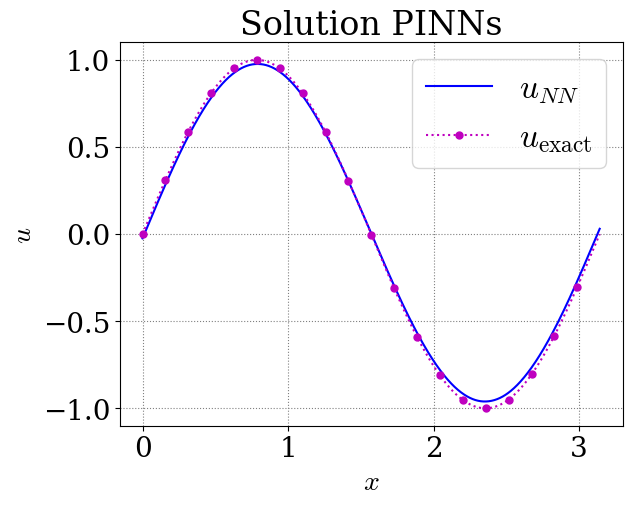

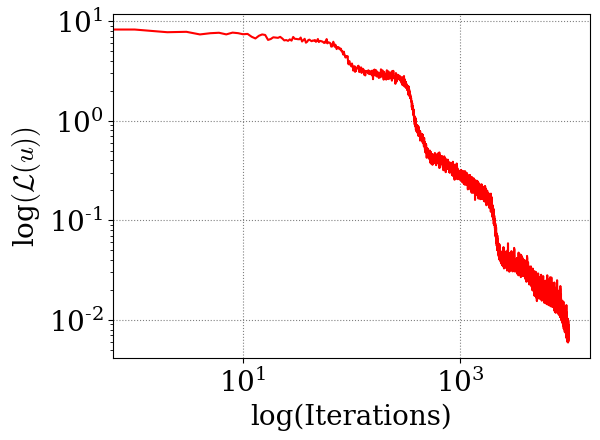

In [ ]:
# =============================================================================
#                Matplotlib Global Style Configuration
# =============================================================================
rcParams['font.family']      = 'serif'
rcParams['font.size']        = 20
rcParams['legend.fontsize']  = 22
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.labelsize']   = 20

# =============================================================================
#                  Prepare Spatial Grid for Plotting
# =============================================================================
# Create 1000 evenly spaced points in [0, π] for evaluating the solutions
xlist = tf.experimental.numpy.linspace(
    0.0, np.pi, num=1000, dtype='float32'
)

# =============================================================================
#                Plot Neural Network Solution vs. Exact Solution
# =============================================================================
fig, ax = plt.subplots()

# Plot the PINN-predicted solution u_NN(x)
ax.plot(
    xlist,
    U_model(xlist),
    color='b',
    label=r'$u_{NN}$'
)

# Plot the exact analytical solution u_exact(x)
ax.plot(
    xlist,
    uexact(xlist),
    linestyle='dotted',
    color='m',
    marker='.',
    markersize=10,
    markevery=50,
    label=r'$u_{\mathrm{exact}}$'
)

# Add grid, labels, and title
ax.grid(which='major', axis='both', linestyle=':', color='gray')
plt.title('Solution PINNs')
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.legend(fontsize=24)
plt.tight_layout()

# Save the figure as PDF
plt.savefig("plot_sol_PINN.pdf", format="pdf", bbox_inches="tight")

# Display on screen
plt.show()


# =============================================================================
#                   Plot Training Loss Evolution vs. Iterations
# =============================================================================
# Extract loss history from training
Loss_rel = history.history['loss']

fig, ax = plt.subplots()

# Plot the loss curve over epochs
ax.plot(
    Loss_rel,
    color='r'
)

# Set both axes to logarithmic scale to capture decay behavior
ax.set_xscale('log')
ax.set_yscale('log')

# Add grid, labels, and title
ax.grid(which='major', axis='both', linestyle=':', color='gray')
plt.xlabel('Iterations')
plt.ylabel(r'$\mathcal{L}(u)$')
plt.tight_layout()

# Save the loss plot as PDF
plt.savefig("plot_loss_PINN.pdf", format="pdf", bbox_inches="tight")

# Display on screen
plt.show()